In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# @title Imports
!pip install tensorflow

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from drive.MyDrive.stocks.pretrained_rl_ppo.scr.check_data import prepare_time_series
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.dataset_builder import DatasetBuilderForYourColumns
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.ppo_training import train, prepare_datasets, testing_simulation
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.backtest_env import BacktestEnv, EnvConfig
from drive.MyDrive.stocks.pretrained_rl_ppo.scr.indicators import *

In [2]:
# @title Load and check data

# PATH_TO_DATA = "dummy_df.joblib"  # <-- provide path
PATH_TO_DATA = "/content/drive/MyDrive/stocks/Data/DOGEUSDT/raw_data/DOGEUSDT_1m_2024-01-01_to_2025-05-23.joblib"
START = "2024-01-20"
END = "2025-05-23"
TIMESTAMP_COL = "timestamp"          # column with timestamps

raw_df = joblib.load(PATH_TO_DATA).loc[START:END]
df = prepare_time_series(raw_df, timestamp_col=TIMESTAMP_COL)
print(f"From {df.index[0]} to {df.index[-1]}")

From 2024-01-20 00:00:00+00:00 to 2025-05-23 23:59:00+00:00


In [3]:
# @title Add indicators

# Базовые массивы (создаём один раз)
close  = df['Close'].to_numpy(np.float64)
high   = df['High'].to_numpy(np.float64)
low    = df['Low'].to_numpy(np.float64)
volume = df['Volume'].to_numpy(np.float64)

# Словарь для новых колонок
new_cols = {}
obv_arr = obv_numba(close, volume)

for i in range(35, 246, 7):
    ema_i = ema_numba(close, i)
    sma_i = sma_numba(close, i)
    adx_i = adx_numba(high, low, close, i)
    atr_i = atr_numba(high, low, close, i)
    rsi_i = rsi_numba(close, i)

    fast = i
    slow = i * 2
    sig  = i // 2  # вместо int(i/2)

    macd, macd_signal, macd_hist = macd_numba(close, fast, slow, sig)
    stoch_k, stoch_d = stoch_numba(high, low, close, i, i // 2)
    boll_mid, boll_up, boll_dn = bollinger_numba(close, i, 2.0)
    cci_i  = cci_numba(high, low, close, i)
    willr_i= williams_r_numba(high, low, close, i)
    mfi_i  = mfi_numba(high, low, close, volume, i)
    roc_i  = roc_numba(close, i)
    vwap_i = vwap_numba(high, low, close, volume, i)  # если это rolling VWAP на окне i

    new_cols.update({
        f"EMA_{i}":          ema_i,
        f"SMA_{i}":          sma_i,
        f"ADX_{i}":          adx_i,
        f"ATR_{i}":          atr_i,
        f"RSI_{i}":          rsi_i,
        f"MACD_{i}":         macd,
        f"MACD_signal_{i}":  macd_signal,
        f"MACD_hist_{i}":    macd_hist,
        f"STOCH_K_{i}":      stoch_k,
        f"STOCH_D_{i}":      stoch_d,
        f"BOLL_MID_{i}":     boll_mid,
        f"BOLL_UP_{i}":      boll_up,
        f"BOLL_DN_{i}":      boll_dn,
        f"OBV":              obv_arr,
        f"CCI_{i}":          cci_i,
        f"WILLR_{i}":        willr_i,
        f"MFI_{i}":          mfi_i,
        f"ROC_{i}":          roc_i,
        f"VWAP_{i}":         vwap_i,
    })

# Добавляем все столбцы разом — без фрагментации
df = pd.concat([df, pd.DataFrame(new_cols, index=df.index)], axis=1)

print(df.columns.to_list())

['timestamp', 'Open', 'High', 'Low', 'Close', 'Volume', 'EMA_35', 'SMA_35', 'ADX_35', 'ATR_35', 'RSI_35', 'MACD_35', 'MACD_signal_35', 'MACD_hist_35', 'STOCH_K_35', 'STOCH_D_35', 'BOLL_MID_35', 'BOLL_UP_35', 'BOLL_DN_35', 'OBV', 'CCI_35', 'WILLR_35', 'MFI_35', 'ROC_35', 'VWAP_35', 'EMA_42', 'SMA_42', 'ADX_42', 'ATR_42', 'RSI_42', 'MACD_42', 'MACD_signal_42', 'MACD_hist_42', 'STOCH_K_42', 'STOCH_D_42', 'BOLL_MID_42', 'BOLL_UP_42', 'BOLL_DN_42', 'CCI_42', 'WILLR_42', 'MFI_42', 'ROC_42', 'VWAP_42', 'EMA_49', 'SMA_49', 'ADX_49', 'ATR_49', 'RSI_49', 'MACD_49', 'MACD_signal_49', 'MACD_hist_49', 'STOCH_K_49', 'STOCH_D_49', 'BOLL_MID_49', 'BOLL_UP_49', 'BOLL_DN_49', 'CCI_49', 'WILLR_49', 'MFI_49', 'ROC_49', 'VWAP_49', 'EMA_56', 'SMA_56', 'ADX_56', 'ATR_56', 'RSI_56', 'MACD_56', 'MACD_signal_56', 'MACD_hist_56', 'STOCH_K_56', 'STOCH_D_56', 'BOLL_MID_56', 'BOLL_UP_56', 'BOLL_DN_56', 'CCI_56', 'WILLR_56', 'MFI_56', 'ROC_56', 'VWAP_56', 'EMA_63', 'SMA_63', 'ADX_63', 'ATR_63', 'RSI_63', 'MACD_63', 

In [4]:
# @title Параметры

SPLITS = (0.8, 0.10, 0.10)
SEQ_LEN = 5
BEST_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/best_lstm.weights.h5"
BEST_BACKBONE_PATH = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/sl_weights/exp1/best_backbone.weights.h5"


FEE = 0.0002
SLIPPAGE = 0.0001
T = None

FEATURES = ['Open', 'High', 'Low', 'Close', 'Volume']
for i in [189, 210, 217]:
  inds = [f'EMA_{i}', f'SMA_{i}', f'ADX_{i}', f'ATR_{i}', f'RSI_{i}', f'MACD_{i}', f'MACD_signal_{i}', f'MACD_hist_{i}',
      f'STOCH_K_{i}', f'STOCH_D_{i}', f'BOLL_MID_{i}', f'BOLL_UP_{i}', f'BOLL_DN_{i}',
      f'CCI_{i}', f'WILLR_{i}', f'MFI_{i}', f'ROC_{i}', f'VWAP_{i}']
  FEATURES = FEATURES + inds

ACCOUNT_F = [
    "Unreal_PnL", "Flat_Steps", "Hold_Steps", "Drawdown", "Pos",
]

# @title PPO training parameters


PPO_SEQ_LEN = SEQ_LEN
PPO_FEATURES_DIM = len(FEATURES) + len(ACCOUNT_F)
PPO_SAVE_PATH = '/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp1'
PPO_NUM_ACTIONS = 4
PPO_UNITS_PER_LAYER = [64]
PPO_DROPOUT = 0.5
# PPO params
PPO_UPDATES = 10
PPO_N_ENV = 40
PPO_ROLLOUT = 512
PPO_ACTOR_LR = 3e-4
PPO_CRITIC_LR = 1e-3
PPO_CLIP_RATIO = 0.2
PPO_C1 = 0.5
PPO_C2 = 0.01
PPO_EPOCHS = 10
PPO_BATCH_SIZE = 64
PPO_TEACHER_KL = 0.1
PPO_KL_DECAY = 0.98
PPO_TARGET_KL = 0.01
PPO_MAX_GRAD_NORM = 0.5
PPO_VAL_INTERVAL = 1
PPO_DEBUG = True


In [5]:
    # Подготавливаем данные и вычисляем статистики нормализации
ppo_train_df, ppo_val_df, ppo_test_df, _feat_stats = prepare_datasets(df,
                                                                      FEATURES,
                                                                      splits=SPLITS,
                                                                      norm_kind='minmax')

train: debug mode enabled
CPU available: 44
Teacher policy
evaluate_profit metrics={'Realized PnL': 0.0299, 'Annual Return': 0.0036, 'Sharpe Ratio': 0.2006, 'Sortino Ratio': 0.1985, 'Closed trades': 16, 'Avg PnL per trade': 0.0021, 'Maximum Drawdown': 2.018, 'Calmar Ratio': 0.0018, 'Profit Factor': 2.6604, 'Win Rate': 62.5, 'Average Win/Loss Ratio': 1.5963, 'Recovery Factor': 0.0148, 'Time Under Water': 0.8397, 'Value at Risk': 0.0017}


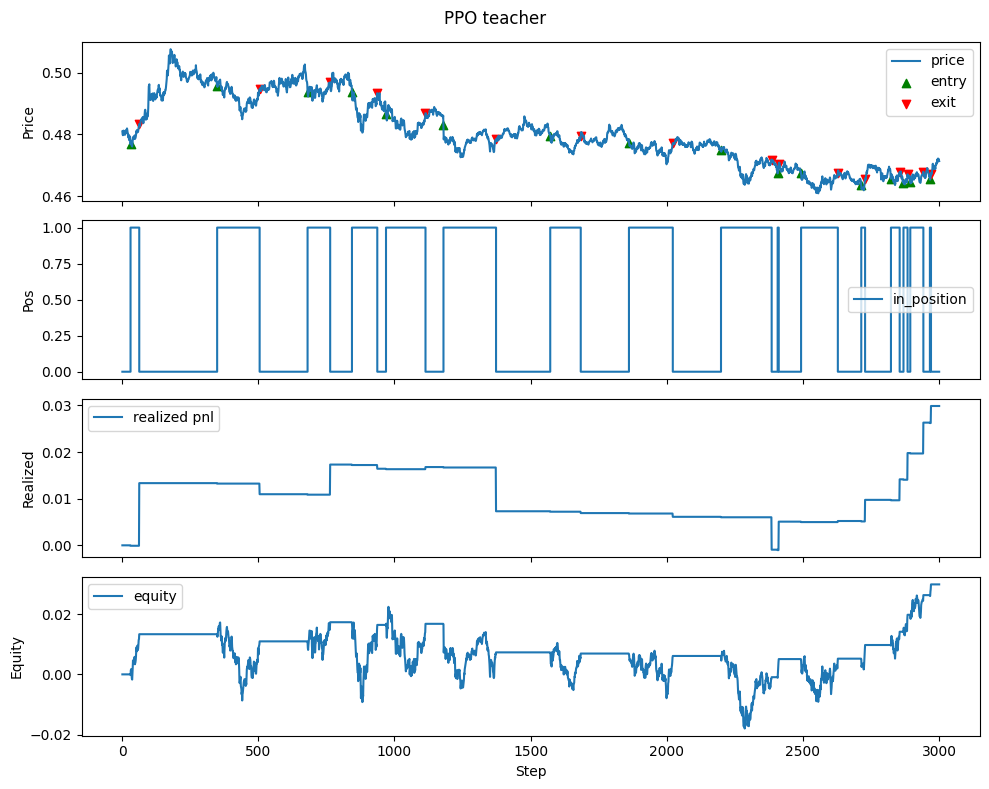

collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.00164 value_loss=1.38971 entropy=0.44695 approx_kl=0.02611
ppo_update: epoch 2/10
batch: policy_loss=0.03193 value_loss=0.94573 entropy=0.44952 approx_kl=0.01053
ppo_update: epoch 3/10
batch: policy_loss=-0.00912 value_loss=1.21816 entropy=0.44122 approx_kl=0.00416
batch: policy_loss=0.09607 value_loss=0.73711 entropy=0.44269 approx_kl=-0.03560
batch: policy_loss=-0.01270 value_loss=1.14611 entropy=0.43946 approx_kl=0.00808
batch: policy_loss=-0.00239 value_loss=1.13575 entropy=0.40482 approx_kl=-0.04808
batch: policy_loss=0.01752 value_loss=0.89859 entropy=0.41587 approx_kl=0.00195
batch: policy_loss=0.00087 value_loss=0.69084 entropy=0.34416 approx_kl=0.01523
ppo_update: epoch 4/10
batch: policy_loss=0.00142 value_loss=0.78029 entropy=0.36574 approx_kl=0.03863
ppo_update: epoch 5/10
batch: policy_loss=0.08156 value_loss=0.74929 entropy=0.46375 approx_kl=-0.02578
batch: policy_loss=0.00133

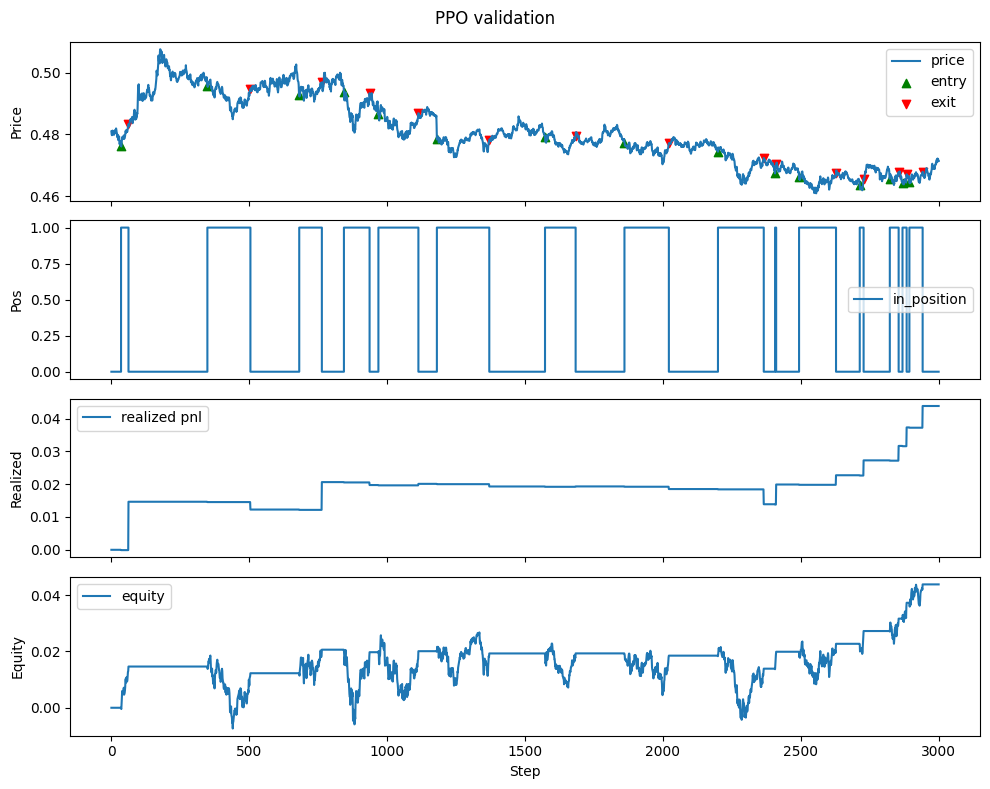

update=0 avg_reward=-0.553 profit=0.044 kl_coef=0.0980
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.01344 value_loss=0.69939 entropy=0.41142 approx_kl=0.03922
ppo_update: epoch 2/10
batch: policy_loss=0.01375 value_loss=0.96051 entropy=0.38389 approx_kl=0.03685
ppo_update: epoch 3/10
batch: policy_loss=0.01362 value_loss=0.80166 entropy=0.42023 approx_kl=0.01499
ppo_update: epoch 4/10
batch: policy_loss=-0.01089 value_loss=0.67377 entropy=0.40414 approx_kl=0.02508
ppo_update: epoch 5/10
batch: policy_loss=-0.00137 value_loss=0.53180 entropy=0.40781 approx_kl=0.01504
ppo_update: epoch 6/10
batch: policy_loss=0.01393 value_loss=0.46636 entropy=0.40864 approx_kl=0.01698
ppo_update: epoch 7/10
batch: policy_loss=-0.00042 value_loss=0.48935 entropy=0.36668 approx_kl=-0.00403
batch: policy_loss=0.00590 value_loss=0.39724 entropy=0.35106 approx_kl=0.04431
ppo_update: epoch 8/10
batch: policy_loss=0.00805 value_loss=0.44684 entropy=0.39615 ap

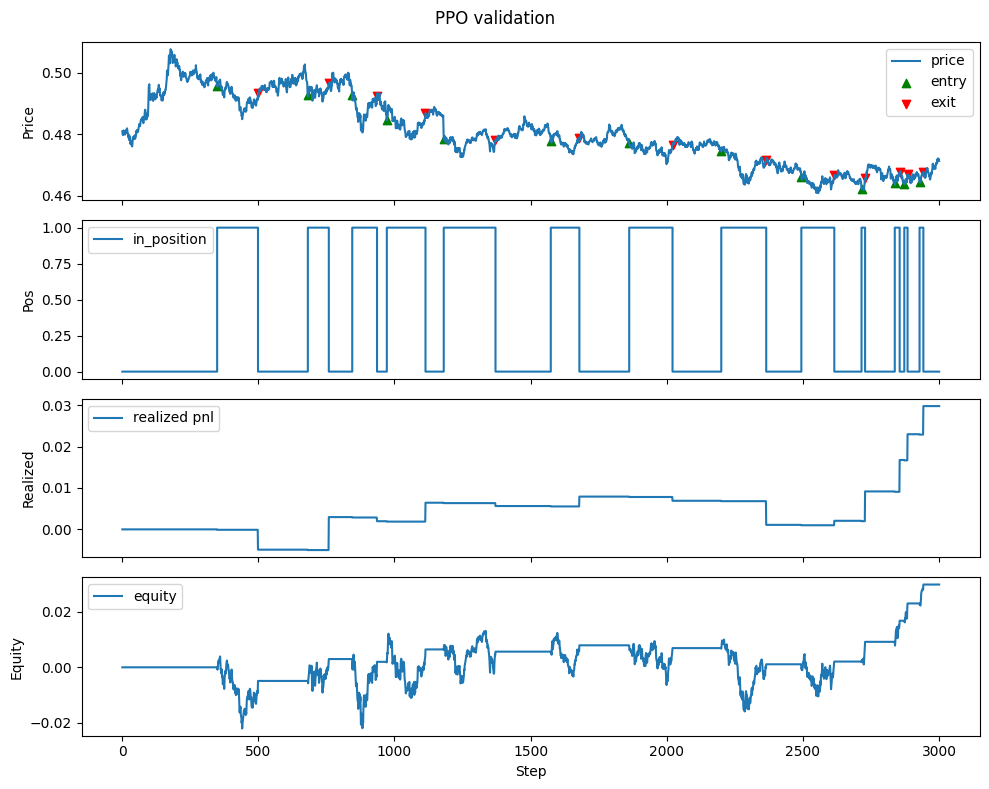

update=1 avg_reward=0.029 profit=0.030 kl_coef=0.0960
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.00380 value_loss=0.74337 entropy=0.39172 approx_kl=-0.00288
batch: policy_loss=0.00055 value_loss=0.52336 entropy=0.40786 approx_kl=0.02872
ppo_update: epoch 2/10
batch: policy_loss=0.00295 value_loss=0.53463 entropy=0.41838 approx_kl=-0.00126
batch: policy_loss=0.02648 value_loss=0.56023 entropy=0.39856 approx_kl=0.01828
ppo_update: epoch 3/10
batch: policy_loss=0.01075 value_loss=0.31599 entropy=0.40596 approx_kl=0.03320
ppo_update: epoch 4/10
batch: policy_loss=0.02930 value_loss=0.42462 entropy=0.43468 approx_kl=0.01189
ppo_update: epoch 5/10
batch: policy_loss=0.00542 value_loss=0.27683 entropy=0.42544 approx_kl=0.01094
ppo_update: epoch 6/10
batch: policy_loss=0.04017 value_loss=0.27976 entropy=0.40305 approx_kl=-0.00434
batch: policy_loss=0.02864 value_loss=0.34639 entropy=0.41299 approx_kl=-0.00611
batch: policy_loss=0.01533 valu

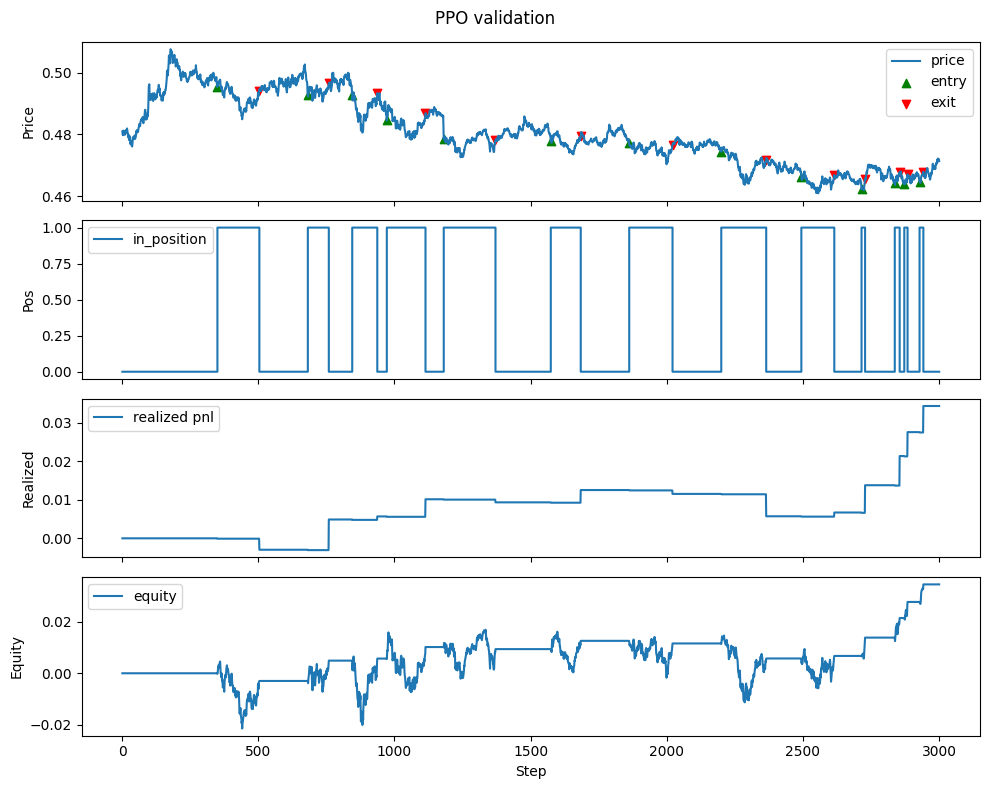

update=2 avg_reward=0.617 profit=0.034 kl_coef=0.0941
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=-0.01316 value_loss=0.38197 entropy=0.38044 approx_kl=0.02040
ppo_update: epoch 2/10
batch: policy_loss=0.01532 value_loss=0.27318 entropy=0.38154 approx_kl=0.01972
ppo_update: epoch 3/10
batch: policy_loss=0.02653 value_loss=0.31352 entropy=0.39706 approx_kl=-0.00744
batch: policy_loss=0.00197 value_loss=0.39627 entropy=0.40013 approx_kl=0.03711
ppo_update: epoch 4/10
batch: policy_loss=0.00791 value_loss=0.33010 entropy=0.40705 approx_kl=0.02932
ppo_update: epoch 5/10
batch: policy_loss=-0.00251 value_loss=0.26209 entropy=0.38748 approx_kl=0.02779
ppo_update: epoch 6/10
batch: policy_loss=0.01781 value_loss=0.22299 entropy=0.39899 approx_kl=0.00380
batch: policy_loss=0.00916 value_loss=0.28559 entropy=0.35960 approx_kl=0.02555
ppo_update: epoch 7/10
batch: policy_loss=0.01521 value_loss=0.19779 entropy=0.38508 approx_kl=0.01635
ppo_updat

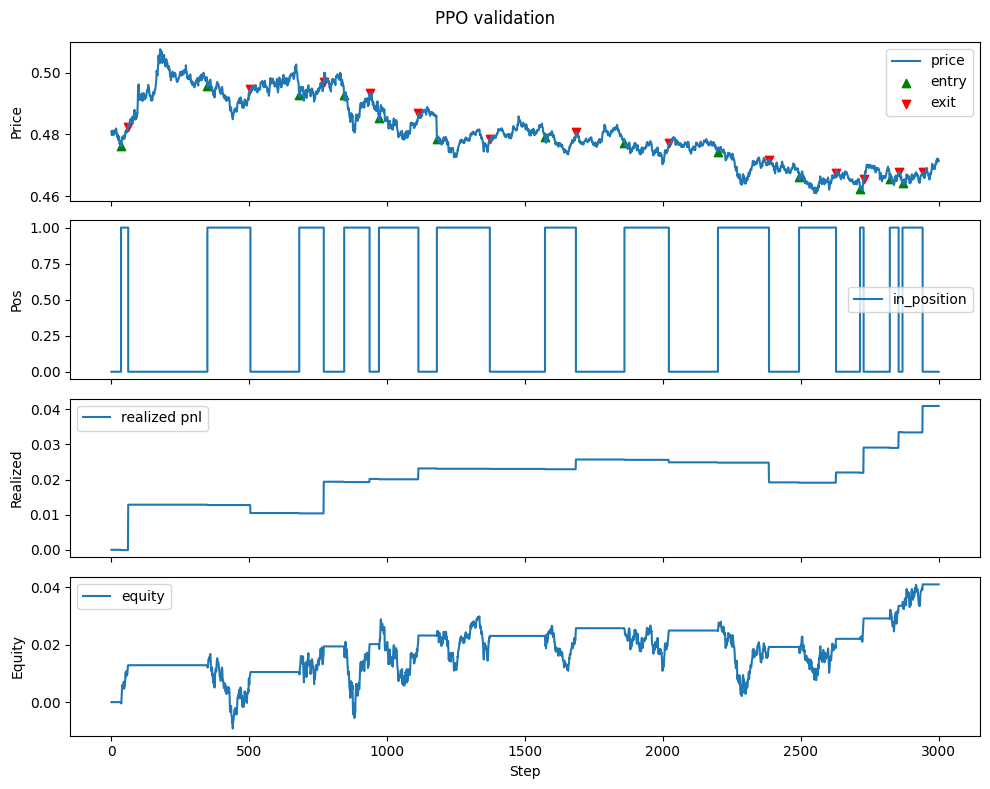

update=3 avg_reward=0.947 profit=0.041 kl_coef=0.0922
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.01475 value_loss=0.24950 entropy=0.40323 approx_kl=-0.01469
batch: policy_loss=0.01064 value_loss=0.29387 entropy=0.40936 approx_kl=-0.01755
batch: policy_loss=0.01445 value_loss=0.31052 entropy=0.38473 approx_kl=0.03095
ppo_update: epoch 2/10
batch: policy_loss=0.00554 value_loss=0.26046 entropy=0.34831 approx_kl=-0.00172
batch: policy_loss=0.01187 value_loss=0.24084 entropy=0.35896 approx_kl=-0.00034
batch: policy_loss=0.00910 value_loss=0.29651 entropy=0.40848 approx_kl=-0.00267
batch: policy_loss=0.02816 value_loss=0.28909 entropy=0.33714 approx_kl=0.00485
batch: policy_loss=-0.00531 value_loss=0.26902 entropy=0.38191 approx_kl=-0.00849
batch: policy_loss=0.03331 value_loss=0.17266 entropy=0.35951 approx_kl=0.04691
ppo_update: epoch 3/10
batch: policy_loss=-0.00109 value_loss=0.19665 entropy=0.34293 approx_kl=0.00850
batch: policy_lo

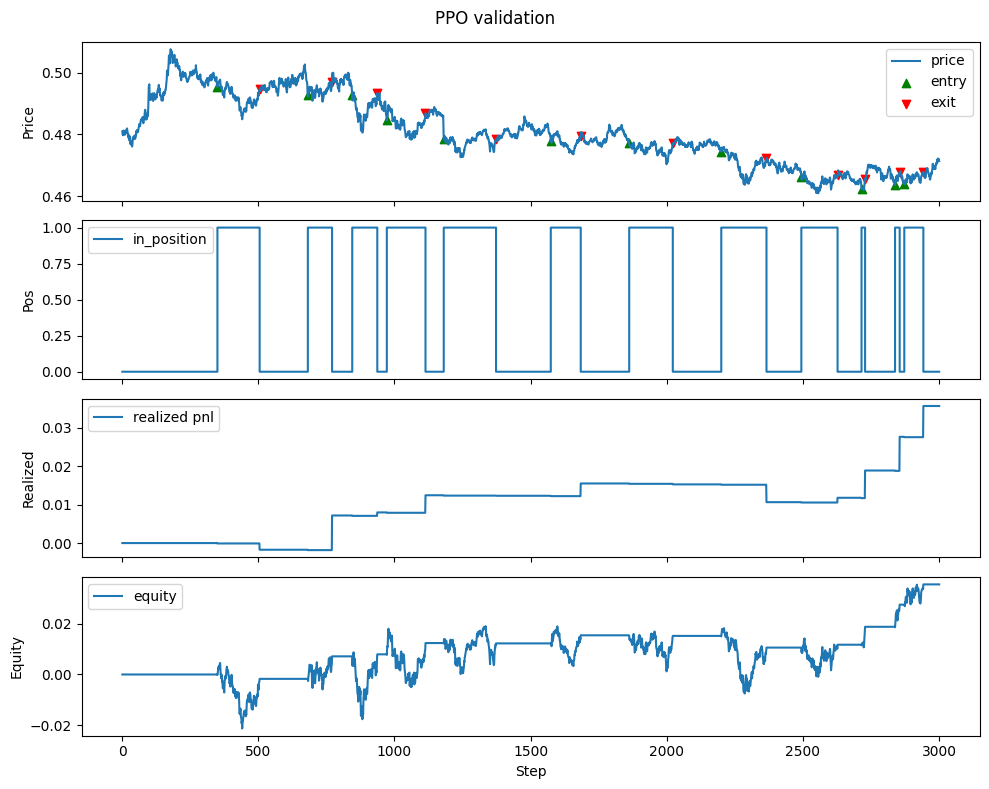

update=4 avg_reward=1.166 profit=0.036 kl_coef=0.0904
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=-0.00296 value_loss=0.21398 entropy=0.34796 approx_kl=-0.01406
batch: policy_loss=0.00799 value_loss=0.17281 entropy=0.36224 approx_kl=-0.00322
batch: policy_loss=0.02894 value_loss=0.09965 entropy=0.35538 approx_kl=-0.00194
batch: policy_loss=0.00844 value_loss=0.14094 entropy=0.35218 approx_kl=0.01906
ppo_update: epoch 2/10
batch: policy_loss=0.00071 value_loss=0.14593 entropy=0.30427 approx_kl=0.02288
ppo_update: epoch 3/10
batch: policy_loss=-0.00384 value_loss=0.10156 entropy=0.33846 approx_kl=0.02802
ppo_update: epoch 4/10
batch: policy_loss=0.00460 value_loss=0.11638 entropy=0.33279 approx_kl=0.01117
ppo_update: epoch 5/10
batch: policy_loss=0.00867 value_loss=0.07082 entropy=0.37034 approx_kl=-0.00345
batch: policy_loss=0.02139 value_loss=0.10444 entropy=0.36164 approx_kl=0.01111
ppo_update: epoch 6/10
batch: policy_loss=-0.00974 v

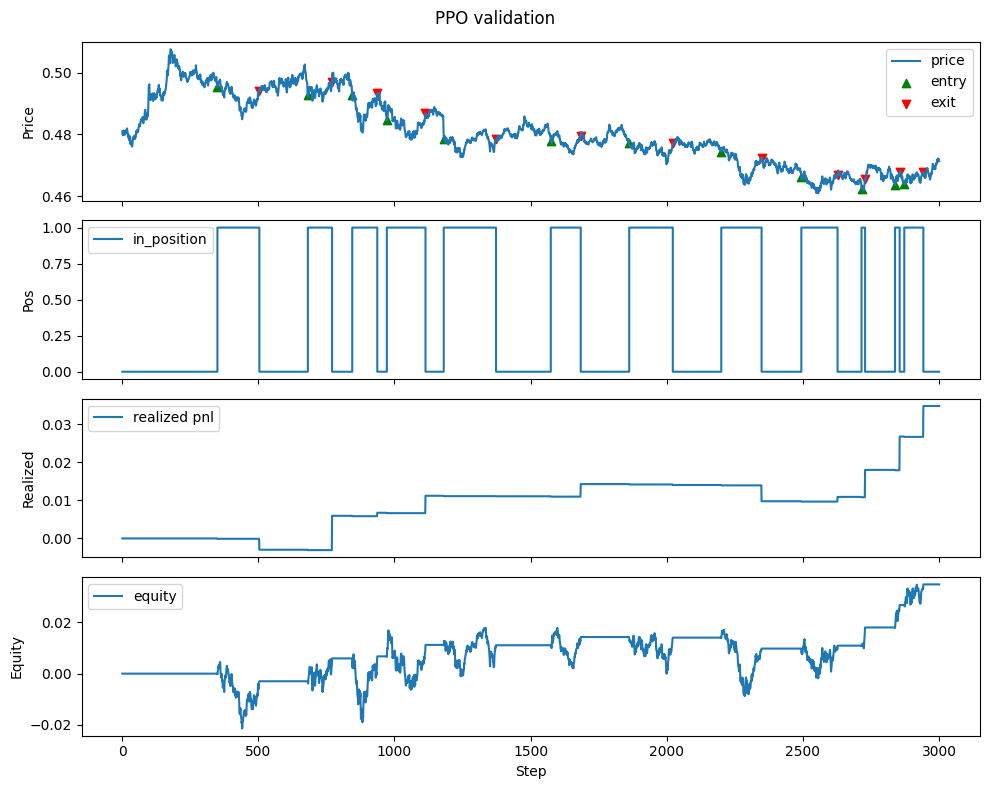

update=5 avg_reward=0.878 profit=0.035 kl_coef=0.0886
collect_trajectories: n_env=40 rollout=512 seq_len=5
ppo_update: epoch 1/10
batch: policy_loss=0.00109 value_loss=0.12766 entropy=0.31596 approx_kl=0.01072
ppo_update: epoch 2/10
batch: policy_loss=-0.00352 value_loss=0.11377 entropy=0.35544 approx_kl=0.00191
batch: policy_loss=-0.01143 value_loss=0.11858 entropy=0.33457 approx_kl=0.01302
ppo_update: epoch 3/10
batch: policy_loss=0.03493 value_loss=0.10493 entropy=0.33914 approx_kl=0.01659
ppo_update: epoch 4/10
batch: policy_loss=0.01551 value_loss=0.13950 entropy=0.33368 approx_kl=0.02218
ppo_update: epoch 5/10
batch: policy_loss=0.01733 value_loss=0.15352 entropy=0.35305 approx_kl=-0.01456
batch: policy_loss=0.02150 value_loss=0.13971 entropy=0.33933 approx_kl=-0.03227
batch: policy_loss=-0.00096 value_loss=0.11468 entropy=0.37014 approx_kl=0.02553
ppo_update: epoch 6/10
batch: policy_loss=0.00253 value_loss=0.08216 entropy=0.30648 approx_kl=-0.00068
batch: policy_loss=0.01335 va

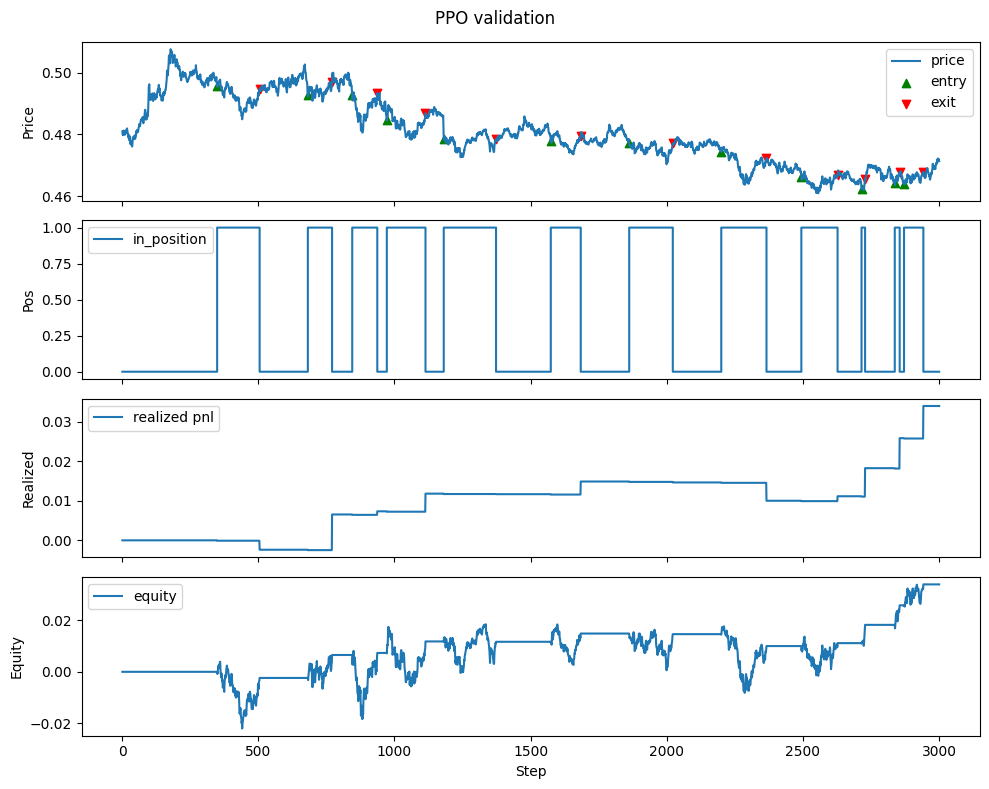

update=6 avg_reward=0.628 profit=0.034 kl_coef=0.0868
collect_trajectories: n_env=40 rollout=512 seq_len=5


Process ForkProcess-299:
Process ForkProcess-314:
Process ForkProcess-319:
Process ForkProcess-304:
Process ForkProcess-302:
Process ForkProcess-288:
Process ForkProcess-296:
Process ForkProcess-320:
Process ForkProcess-295:
Process ForkProcess-293:
Process ForkProcess-297:
Process ForkProcess-301:
Process ForkProcess-291:
Process ForkProcess-305:
Process ForkProcess-298:
Process ForkProcess-284:
Process ForkProcess-290:
Process ForkProcess-313:
Process ForkProcess-309:
Process ForkProcess-308:
Process ForkProcess-292:
Process ForkProcess-281:
Process ForkProcess-289:
Process ForkProcess-307:
Process ForkProcess-300:
Process ForkProcess-286:
Process ForkProcess-316:
Process ForkProcess-294:
Process ForkProcess-317:
Process ForkProcess-285:
Process ForkProcess-282:
Process ForkProcess-312:
Process ForkProcess-287:
Process ForkProcess-318:
Process ForkProcess-303:
Process ForkProcess-283:
Process ForkProcess-306:
Process ForkProcess-315:
Traceback (most recent call last):
Traceback (most

KeyboardInterrupt: 

In [6]:
TRAIN_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=PPO_ROLLOUT+PPO_SEQ_LEN,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

VAL_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=3000,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

TEST_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=1e9,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)


actor, critic, train_log, val_log = train(
    ppo_train_df,
    ppo_val_df,
    ppo_test_df,
    TRAIN_CFG,
    VAL_CFG,
    TEST_CFG,
    PPO_FEATURES_DIM,
    FEATURES,
    seq_len = PPO_SEQ_LEN,
    teacher_weights = BEST_PATH,
    backbone_weights = BEST_BACKBONE_PATH,
    save_path = PPO_SAVE_PATH,
    num_actions = PPO_NUM_ACTIONS,
    units_per_layer = PPO_UNITS_PER_LAYER,
    dropout = PPO_DROPOUT,
    updates = PPO_UPDATES,
    n_env = PPO_N_ENV,
    rollout = PPO_ROLLOUT,
    actor_lr = PPO_ACTOR_LR,
    critic_lr = PPO_CRITIC_LR,
    clip_ratio = PPO_CLIP_RATIO,
    c1 = PPO_C1,
    c2 = PPO_C2,
    epochs = PPO_EPOCHS,
    batch_size = PPO_BATCH_SIZE,
    teacher_kl = PPO_TEACHER_KL,
    kl_decay = PPO_KL_DECAY,
    max_grad_norm = PPO_MAX_GRAD_NORM,
    target_kl = PPO_TARGET_KL,
    val_interval = PPO_VAL_INTERVAL,
    debug = PPO_DEBUG
)

In [ ]:
from re import S
# @title Test simulation
ACTOR_WEIGHTS = "/content/drive/MyDrive/stocks/pretrained_rl_ppo/ppo_weights/exp1/actor_best_0.weights.h5"
START = "2024-01-20"
END = "2025-05-23"
TEST_FROM = "2025-01-23"

dataframe = df.loc[START:END]

_,_,test_df, _ = prepare_datasets(dataframe,
                                  FEATURES,
                                  test_from=TEST_FROM,
                                  norm_kind='minmax')

TEST_CFG = EnvConfig(
    mode=1,
    fee=FEE,
    spread=SLIPPAGE,
    leverage=1.0,
    max_steps=1e9,
    reward_scale=1.0,
    use_log_reward=False,
    time_penalty=0.0,
    hold_penalty=0.0,
)

testing_simulation(
    test_df,
    ACTOR_WEIGHTS,
    SEQ_LEN,
    PPO_FEATURES_DIM,
    PPO_UNITS_PER_LAYER,
    PPO_DROPOUT,
    PPO_NUM_ACTIONS,
    FEATURES,
    TEST_CFG,
    debug=False


)